# NDVI STD <a id="top"></a>

Deviations from an established average z-score. 

<hr>  
  
# Notebook Summary

* A baseline for each month is determined by measuring NDVI over a set time
* The data cube is used to visualize at NDVI anomalies over time.
* Anomalous times are further explored and visualization solutions are proposed.

<hr>  

# Algorithmic process  

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platform and Product](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Load Data from the Data Cube](#load_data)
* [Create and Use a Clean Mask](#clean_mask)
* [Calculate the NDVI](#calculate)
* [Convert the Xarray to a Dataframe](#pandas)
* [Define a Function to Visualize Values Over the Region](#visualization_function)
* [Visualize the Baseline Average NDVI by Month](#baseline_mean_ndvi)
* [Visualize the Baseline Distributions Binned by Month](#boxplot_analysis)
* [Visualize the Baseline Kernel Distributions Binned by Month](#violinplot_analysis)
* [Plot Z-Scores by Month and Year](#pixelplot_analysis)
* [Further Examine Times Of Interest](#heatmap_analysis)

<hr>  

# How It Works

To detect changes in plant life, we use a measure called NDVI. 
* <font color=green>NDVI</font> is the ratio of the difference between amount of near infrared light <font color=red>(NIR)</font> and red light <font color=red>(RED)</font> divided by their sum.
<br>

$$ NDVI =  \frac{(NIR - RED)}{(NIR + RED)}$$  

<br>
<div class="alert-info">
The idea is to observe how much red light is being absorbed versus reflected. Photosynthetic plants absorb most of the visible spectrum's wavelengths when they are healthy.  When they aren't healthy, more of that light will get reflected.  This makes the difference between <font color=red>NIR</font> and <font color=red>RED</font> much smaller which will lower the <font color=green>NDVI</font>.  The resulting values from doing this over several pixels can be used to create visualizations for the changes in the amount of photosynthetic vegetation in large areas.
</div>

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top) </span>  

In [1]:
import numpy
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
api = DataAccessApi()
dc = api.dc

## <span id="plat_prod">Choose Platform and Product [&#9652;](#top)</span>

In [2]:
# Change the data platform and data cube here

product = "ls7_usgs_sr_scene"
platform = "LANDSAT_7"

# product = "ls8_usgs_sr_scene"
# platform = "LANDSAT_8"

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [3]:
from utils.data_cube_utilities.dc_load import get_product_extents

full_lat, full_lon, min_max_dates = get_product_extents(api, platform, product)

print("{}:".format(platform))
print("Lat bounds:", full_lat)
print("Lon bounds:", full_lon)
print("Time bounds:", min_max_dates)

LANDSAT_7:
Lat bounds: (-12.57305555565614, 18.32305555570214)
Lon bounds: (-25.66583333353866, 44.05861111146359)
Time bounds: (datetime.datetime(1999, 7, 8, 8, 0, 40, 874000), datetime.datetime(2020, 1, 10, 9, 55, 18, 919000))


## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

In [4]:
from utils.data_cube_utilities.dc_display_map import display_map

display_map(full_lat, full_lon)

In [5]:
params = {'latitude': (0.55, 0.6),
 'longitude': (35.55, 35.5),
 'time': ( '2005-01-01', '2010-12-31')}

In [6]:
display_map(params["latitude"], params["longitude"])

## <span id="load_data">Load Data from the Data Cube [&#9652;](#top)</span>

In [7]:
dataset = dc.load(**params,
                  platform = platform,
                  product = product,
                  measurements = ['red', 'green', 'blue', 'swir1', 'swir2', 'nir', 'pixel_qa']) 
dataset

<xarray.Dataset>
Dimensions:    (latitude: 180, longitude: 181, time: 257)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-08T07:37:57.198923 ... 2010-12-31T07:47:54.842872
  * latitude   (latitude) float64 0.5999 0.5996 0.5993 ... 0.5507 0.5504 0.5501
  * longitude  (longitude) float64 35.5 35.5 35.5 35.5 ... 35.55 35.55 35.55
Data variables:
    red        (time, latitude, longitude) int16 -9999 -9999 ... -9999 -9999
    green      (time, latitude, longitude) int16 -9999 -9999 ... -9999 -9999
    blue       (time, latitude, longitude) int16 -9999 -9999 ... -9999 -9999
    swir1      (time, latitude, longitude) int16 -9999 -9999 ... -9999 -9999
    swir2      (time, latitude, longitude) int16 -9999 -9999 ... -9999 -9999
    nir        (time, latitude, longitude) int16 -9999 -9999 ... -9999 -9999
    pixel_qa   (time, latitude, longitude) uint16 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
Attributes:
    crs:      EPSG:4326

## <span id="clean_mask">Create and Use a Clean Mask [&#9652;](#top)</span>

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# from utils.data_cube_utilities.dc_mosaic import ls7_unpack_qa
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask

#Make a Clean Mask to remove clouds and scanlines
#mask = ls7_unpack_qa(dataset.pixel_qa, "clear")
mask = landsat_qa_clean_mask(dataset, platform)

#Filter the scenes with that clean mask
dataset = dataset.where(mask)

## <span id="calculate">Calculate the NDVI [&#9652;](#top)</span>

In [9]:
#Calculate NDVI
ndvi = (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

## <span id="pandas">Convert the Xarray to a Dataframe</span>  [&#9652;](#top)

In [10]:
import pandas as pd

#Cast to pandas dataframe
df = ndvi.to_dataframe("NDVI")

#flatten the dimensions since it is a compound hierarchical dataframe
df = df.stack().reset_index()

#Drop the junk column that was generated for NDVI
df = df.drop(["level_3"], axis=1)

#Preview first 5 rows to make sure everything looks as it should
df.head()

,time,latitude,longitude,0
0,2005-01-08 07:38:21.119579,0.599861,35.499861,0.714286
1,2005-01-08 07:38:21.119579,0.599861,35.500139,0.724705
2,2005-01-08 07:38:21.119579,0.599861,35.500417,0.724705
3,2005-01-08 07:38:21.119579,0.599861,35.500694,0.774448
4,2005-01-08 07:38:21.119579,0.599861,35.500972,0.814464


In [11]:
#Rename the NDVI column to the appropriate name
df = df.rename(index=str, columns={0: "ndvi"})

#clamp NDVI between 0 and 1
df.ndvi = df.ndvi.clip(lower=0)

#Add columns for Month and Year for convenience
df["Month"] = df.time.dt.month
df["Year"] = df.time.dt.year

#Preview changes
df.head()

,time,latitude,longitude,ndvi,Month,Year
0,2005-01-08 07:38:21.119579,0.599861,35.499861,0.714286,1,2005
1,2005-01-08 07:38:21.119579,0.599861,35.500139,0.724705,1,2005
2,2005-01-08 07:38:21.119579,0.599861,35.500417,0.724705,1,2005
3,2005-01-08 07:38:21.119579,0.599861,35.500694,0.774448,1,2005
4,2005-01-08 07:38:21.119579,0.599861,35.500972,0.814464,1,2005


## <span id="visualization_function">Define a Function to Visualize Values Over the Region [&#9652;](#top)</span>

In [12]:
from matplotlib.ticker import FuncFormatter


#Create a function for formatting our axes
def format_axis(axis, digits = None, suffix = ""):
    
    #Get Labels
    labels = axis.get_majorticklabels()
    
    #Exit if empty
    if len(labels) == 0: return
    
    #Create formatting function
    format_func = lambda x, pos: "{0}{1}".format(labels[pos]._text[:digits],suffix)
    
    #Use formatting function
    axis.set_major_formatter(FuncFormatter(format_func))
    

#Create a function for examining the z-score and NDVI of the region graphically
def examine(month = list(df["time"].dt.month.unique()), year = list(df["time"].dt.year.unique()), value_name = "z_score"):
    
    #This allows the user to pass single floats as values as well
    if type(month) is not list: month = [month]
    if type(year) is not list: year = [year]
          
    #pivoting the table to the appropriate layout
    piv = pd.pivot_table(df[df["time"].dt.year.isin(year) & df["time"].dt.month.isin(month)],
                         values=value_name,index=["latitude"], columns=["longitude"])
   
    #Sizing
    plt.rcParams["figure.figsize"] = [11,11]
    
    #Plot pivot table as heatmap using seaborn
    val_range = (-1.96,1.96) if value_name is "z_score" else (df[value_name].unique().min(),df[value_name].unique().max())
    ax = sns.heatmap(piv, square=False, cmap="RdYlGn",vmin=val_range[0],vmax=val_range[1], center=0)

    #Formatting        
    format_axis(ax.yaxis, 6)
    format_axis(ax.xaxis, 7) 
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90 )
    plt.gca().invert_yaxis()

Lets examine the average <font color=green>NDVI</font> across all months and years to get a look at the region

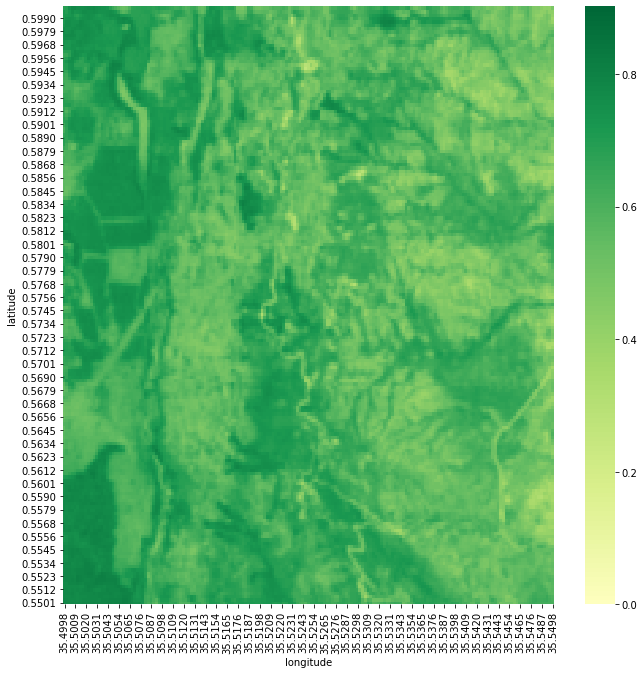

In [13]:
#It defaults to binning the entire range of months and years so we can just leave those parameters out
examine(value_name="ndvi")

This gives us an idea of the healthier areas of the region before we start looking at specific months and years.

## <span id="baseline_mean_ndvi">Visualize the Baseline Average NDVI by Month [&#9652;](#top)</span>

In [14]:
#Make labels for convenience
labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

#Initialize an empty pandas Series
df["z_score"] = pd.Series()

#declare list for population
binned_data = list()

#Calculate monthly binned z-scores from the composited monthly NDVI mean and store them
for i in range(12):
    
    #grab z_score and NDVI for the appropriate month
    temp  = df[["z_score", "ndvi"]][df["Month"] == i+1]
    
    #populate z_score
    df.loc[df["Month"] == i+1,"z_score"] = (temp["ndvi"] - temp["ndvi"].mean())/temp["ndvi"].std(ddof=0)
    
    #print the month next to its mean NDVI and standard deviation
    binned_data.append((labels[i], temp["ndvi"].mean(), temp["ndvi"].std()))

#Create dataframe for binned values
binned_data = pd.DataFrame.from_records(binned_data, columns=["Month","Mean", "Std_Dev"])
    
#print description for clarification
print("Monthly Average NDVI over Baseline Period")

#display binned data
binned_data

Monthly Average NDVI over Baseline Period


,Month,Mean,Std_Dev
0,Jan,0.607390,0.139545
1,Feb,0.522459,0.165161
2,Mar,0.518021,0.149151
3,Apr,0.573377,0.129548
4,May,0.678105,0.109406
5,Jun,0.656898,0.110351
6,Jul,0.575234,0.122805
7,Aug,0.649823,0.115819
8,Sep,0.582332,0.133117
9,Oct,0.644554,0.133208


## <span id="boxplot_analysis">Visualize the Baseline Distributions Binned by Month [&#9652;](#top)</span>

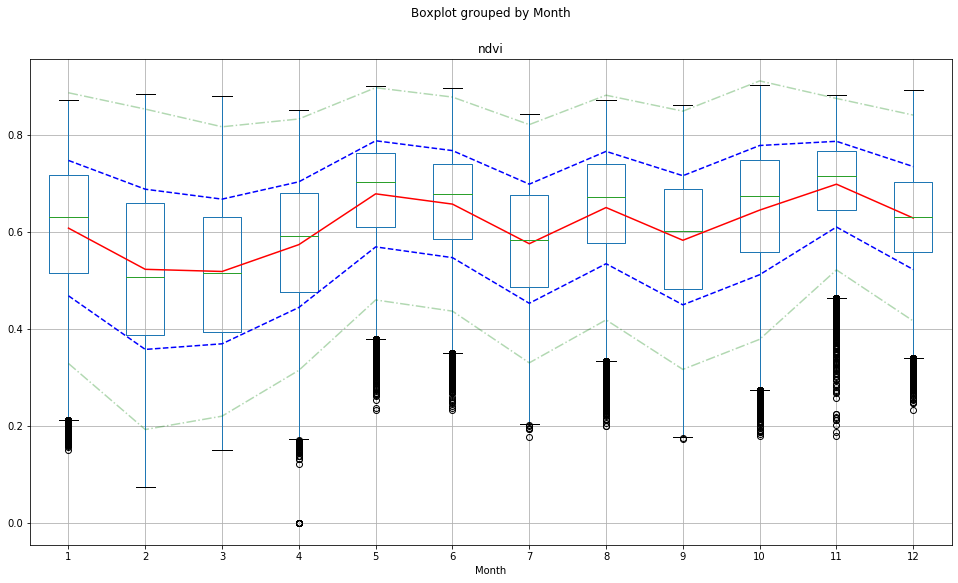

In [15]:
#Set figure size to a larger size
plt.rcParams["figure.figsize"] = [16,9]

#Create the boxplot
df.boxplot(by="Month",column="ndvi")

#Create the mean line
plt.plot(binned_data.index+1, binned_data.Mean, 'r-')

#Create the one standard deviation away lines
plt.plot(binned_data.index+1, binned_data.Mean-binned_data.Std_Dev, 'b--')
plt.plot(binned_data.index+1, binned_data.Mean+binned_data.Std_Dev, 'b--')

#Create the two standard deviations away lines
plt.plot(binned_data.index+1, binned_data.Mean-(2*binned_data.Std_Dev), 'g-.', alpha=.3)
plt.plot(binned_data.index+1, binned_data.Mean+(2*binned_data.Std_Dev), 'g-.', alpha=.3)

The plot above shows the distributions for each individual month over the baseline period.
<br>
- The <b><font color=red>red</font></b> line is the mean line which connects the <b><em>mean values</em></b> for each month.  
    <br>
- The dotted <b><font color=blue>blue</font></b> lines are exactly <b><em>one standard deviation away</em></b> from the mean and show where the NDVI values fall within 68% of the time, according to the Empirical Rule.  
    <br>
- The <b><font color=green>green</font></b> dotted lines are <b><em>two standard deviations away</em></b> from the mean and show where an estimated 95% of the NDVI values are contained for that month.
<br>

<div class="alert-info"><font color=black> <em><b>NOTE: </b>You will notice a seasonal trend in the plot above.  If we had averaged the NDVI without binning, this trend data would be lost and we would end up comparing specific months to the average derived from all the months combined, instead of individually.</em></font>
</div>

## <span id="violinplot_analysis">Visualize the Baseline Kernel Distributions Binned by Month [&#9652;](#top)</span>
The violinplot has the advantage of allowing us to visualize kernel distributions but comes at a higher computational cost

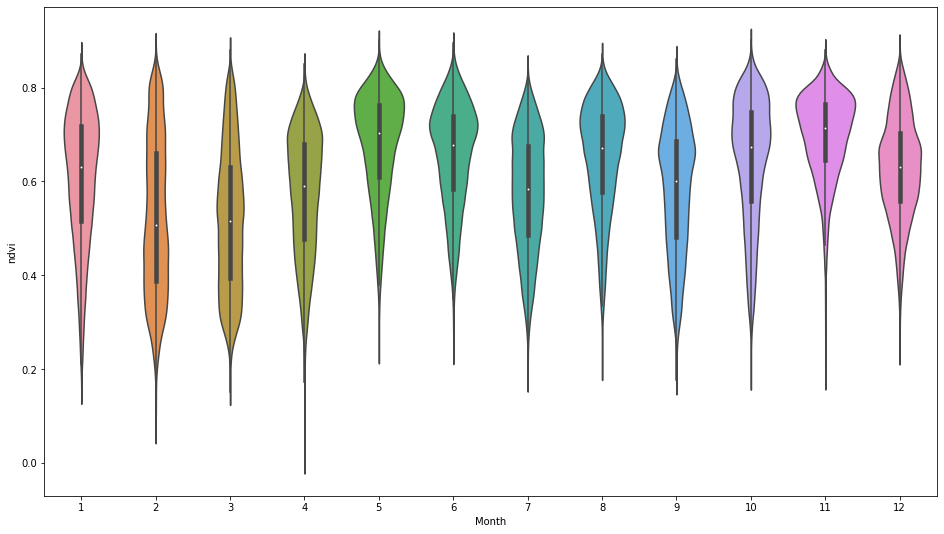

In [16]:
sns.violinplot(x=df.Month, y="ndvi", data=df)

<hr>  

## <span id="pixelplot_analysis">Plot Z-Scores by Month and Year [&#9652;](#top)</span>

### Pixel Plot Visualization

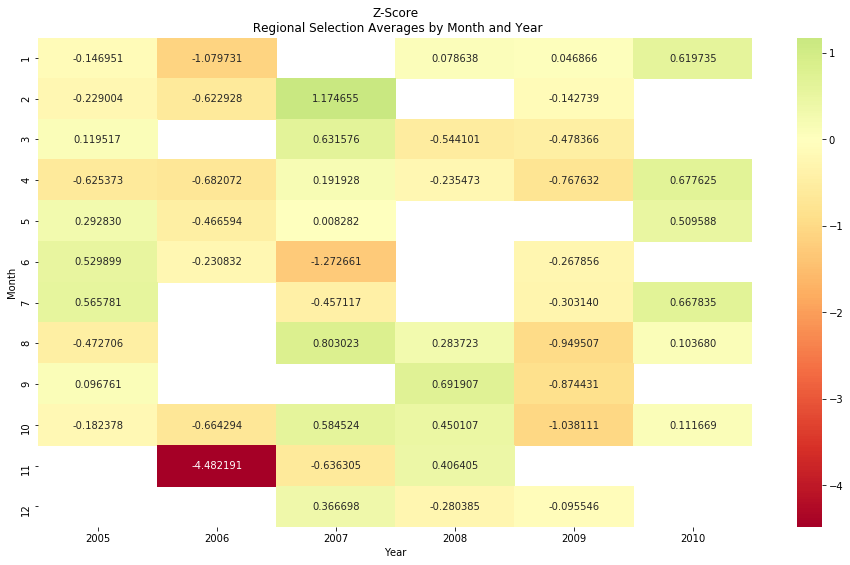

In [17]:
#Create heatmap layout from dataframe
img = pd.pivot_table(df, values="z_score",index=["Month"], columns=["Year"], fill_value=None)

#pass the layout to seaborn heatmap
ax = sns.heatmap(img, cmap="RdYlGn", annot=True, fmt="f", center = 0)

#set the title for Aesthetics
ax.set_title('Z-Score\n Regional Selection Averages by Month and Year')
ax.fill= None

Each block in the visualization above is representative of the deviation from the average for the region selected in a specific month and year.  The omitted blocks are times when there was no satellite imagery available.  Their values must either be inferred, ignored, or interpolated.

You may notice long vertical strips of red.  These are strong indications of drought since they deviate from the baseline consistently over a long period of time. 

## <span id="heatmap_analysis">Further Examine Times Of Interest [&#9652;](#top)</span>

### Use the function we created to examine times of interest

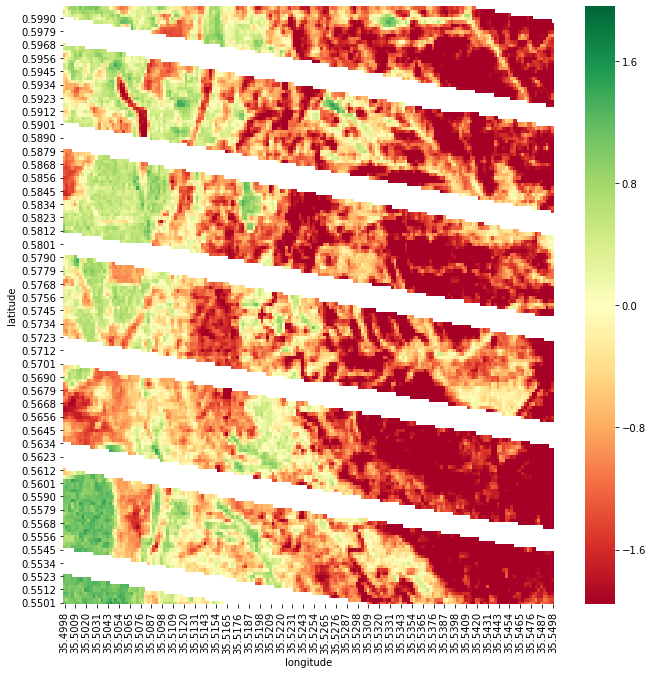

In [18]:
#Lets look at that drought in 2009 during the months of Aug-Oct

#This will generate a composite of the z-scores for the months and years selected
examine(month = [8], year = 2009, value_name="z_score")

Note:
This graphical representation of the region shows the amount of deviation from the mean for each pixel that was binned by month

### Grid Layout of Selected Times

In [19]:
import numpy as np
import matplotlib as mpl
import time

#Restrict input to a maximum of about 12 grids (months*year) for memory
def grid_examine(month = None, year = None, value_name = "z_score"):
    
    #default to all months then cast to list, if not already
    if month is None: month = list(df["Month"].unique())
    elif type(month) is int: month = [month]

    #default to all years then cast to list, if not already
    if year is None: year = list(df["Year"].unique())
    elif type(year) is int: year = [year]

    #get data within the bounds specified
    data = df[np.logical_and(df["Month"].isin(month) , df["Year"].isin(year))]
    
    #Set the val_range to be used as the vertical limit (vmin and vmax)
    val_range = (-1.96,1.96) if value_name is "z_score" else (df[value_name].unique().min(),df[value_name].unique().max())
    
    #create colorbar to export and use on grid
    Z = [[val_range[0],0],[0,val_range[1]]]
    CS3 = plt.contourf(Z, 200, cmap="RdYlGn")
    plt.clf()    
    
    
    #Define facet function to use for each tile in grid
    def heatmap_facet(*args, **kwargs):
        data = kwargs.pop('data')
        img = pd.pivot_table(data, values=value_name,index=["latitude"], columns=["longitude"], fill_value=None)
                
        ax = sns.heatmap(img, cmap="RdYlGn",vmin=val_range[0],vmax=val_range[1],
                         center = 0, square=True, cbar=False, mask = img.isnull())

        plt.setp(ax.xaxis.get_majorticklabels(), rotation=90 )
        plt.gca().invert_yaxis()
    
    
    #Create grid using the face function above
    with sns.plotting_context(font_scale=5.5):
        g = sns.FacetGrid(data, col="Year", row="Month", height=5,sharey=True, sharex=True) 
        mega_g = g.map_dataframe(heatmap_facet, "longitude", "latitude")      
        g.set_titles(col_template="Yr= {col_name}", fontweight='bold', fontsize=18)                         
       
        #Truncate axis tick labels using the format_axis function defined in block 13
        for ax in g.axes:
            format_axis(ax[0]._axes.yaxis, 6)
            format_axis(ax[0]._axes.xaxis, 7)
                
        #create a colorbox and apply the exported colorbar
        cbar_ax = g.fig.add_axes([1.015,0.09, 0.015, 0.90])
        cbar = plt.colorbar(cax=cbar_ax, mappable=CS3)

<Figure size 792x792 with 0 Axes>

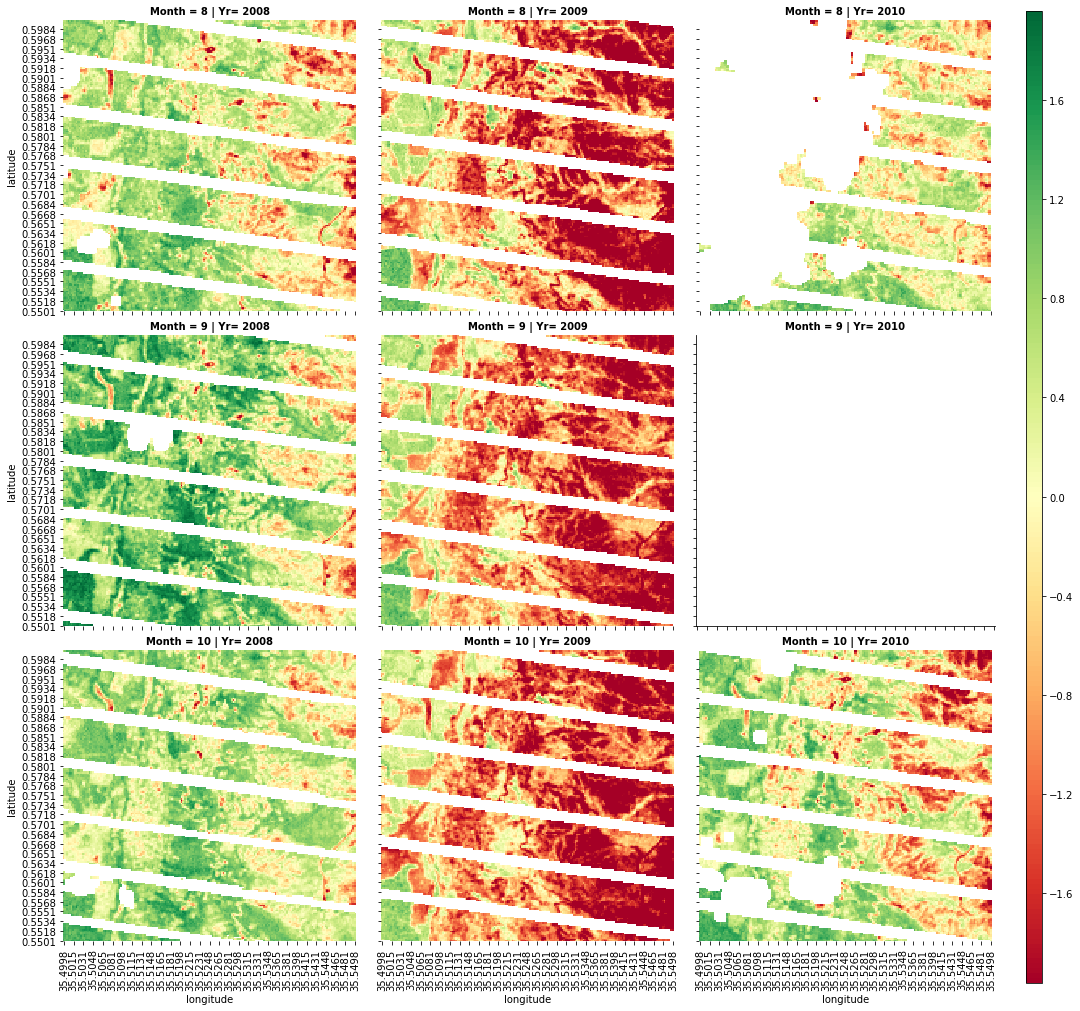

In [20]:
grid_examine(month=[8,9,10], year=[2008,2009,2010])